<a href="https://colab.research.google.com/github/dsilvaa8/GoiEner-project/blob/testing/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [ ]:
def plot_time_series_from_metadata(metadata_df, data_path, thingy, title, rolling=False):
    # Extract unique user names from the 'user' column
    users = metadata_df['user'].unique()
    plt.figure(figsize=(10, 6))
    plt.title(title)
    for user in users:
        # Construct the file path
        file_path = os.path.join(data_path, f"{user}.csv")
        # Check if the file exists
        if os.path.exists(file_path):
            # Load the time series data from the file
            time_series_df = pd.read_csv(file_path)
            mean =  time_series_df["kWh"].mean()
            median = time_series_df["kWh"].median()
            time_series_df = time_series_df.tail(3000)
            if rolling:
                time_series_df["kWh"] = time_series_df["kWh"].rolling(24).mean()
            # Plot the time series
            print("plotting")
            plt.plot(time_series_df['timestamp'], time_series_df['kWh'], thingy ,label=f"Mean: {mean}, Median: {median}")



        else:
            print(f"File not found for user: {user}")
    plt.xlabel('Date')
    plt.ylabel('kwh')
    plt.legend()
    #plt.grid(True)
    print("showing the plot..")
    plt.show()
    return

def load_data(data_path, user):
    file_path = os.path.join(data_path, f"{user}.csv")
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"File not found for user: {user}")
        return None

def prophet_forecast(data, periods, freq='H'):
    data_prophet = data.rename(columns={'timestamp': 'ds', 'kWh': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(data_prophet)
    future_prophet = prophet_model.make_future_dataframe(periods=periods, freq=freq)
    forecast_prophet = prophet_model.predict(future_prophet)
    return forecast_prophet

def arima_forecast(data, periods):
    data_arima = data.set_index('timestamp')['kWh']
    arima_model = ARIMA(data_arima, order=(5,1,0))
    arima_result = arima_model.fit()
    forecast_arima = arima_result.forecast(steps=periods)
    return forecast_arima

def xgboost_forecast(data, periods):
    data_xgb = data.set_index('timestamp')['kWh']
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(np.arange(len(data_xgb)).reshape(-1, 1), data_xgb)
    future_xgb = np.arange(len(data_xgb), len(data_xgb) + periods).reshape(-1, 1)
    forecast_xgb = xgb_model.predict(future_xgb)
    return forecast_xgb

def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def plot_comparison_time_series(metadata_df, data_path, periods, num_weeks=2, displacement_periods=0, sample_rate = 'H',user= None):
    plt.figure(figsize=(10, 6))
    plt.title("Comparison of Time Series and Predictions")

    # Selecting a random user from metadata
    if not user:
        random_user = metadata_df['user'].sample().iloc[0]
        user = random_user
    print("USER: {}".format(user))
    original_data = load_data(data_path, user)  # Load original data without displacement
    if original_data is None:
        return

    original_data['timestamp'] = pd.to_datetime(original_data['timestamp'])  # Convert timestamp to datetime

    # Displace time series backward

    predict_data = original_data[:-displacement_periods]

    print(len(original_data))
    print(len(predict_data))
    start_date = original_data['timestamp'].max() - pd.DateOffset(weeks=num_weeks)
    original_plot_data = original_data[original_data['timestamp'] >= start_date]


    if sample_rate == 'D':
        predict_data = predict_data.resample('D', on='timestamp', kind= 'timestamp', origin = 'end').sum()
        predict_data = predict_data.reset_index()
        original_plot_data = original_plot_data.resample('D', on='timestamp', kind= 'timestamp', origin = 'end').sum()
        original_plot_data = original_plot_data.reset_index()




    prophet_data = predict_data.copy()
    arima_data = predict_data.copy()
    xgboost_data = predict_data.copy()

    # Fit models using the full time series data
    prophet_forecast_data = prophet_forecast(prophet_data, periods, freq = sample_rate)
    arima_forecast_data = arima_forecast(arima_data, periods)
    xgboost_forecast_data = xgboost_forecast(xgboost_data, periods)

    # Plot only the last few weeks of the original data


    plt.plot(original_plot_data['timestamp'], original_plot_data['kWh'], label='Actual', color='black')

    # Truncate Prophet forecast data
    prophet_forecast_data = prophet_forecast_data[prophet_forecast_data['ds'] >= start_date]
    plt.plot(prophet_forecast_data['ds'], prophet_forecast_data['yhat'], label='Prophet', linestyle='--')

    if sample_rate == 'H':
        sample_rate = 'h'
    arima_forecast_dates = predict_data['timestamp'].iloc[-1] + pd.to_timedelta(np.arange(1, periods + 1), unit=sample_rate)
    plt.plot(arima_forecast_dates, arima_forecast_data, label='ARIMA', linestyle='-.')

    xgboost_forecast_dates = predict_data['timestamp'].iloc[-1] + pd.to_timedelta(np.arange(1, periods + 1), unit=sample_rate)
    plt.plot(xgboost_forecast_dates, xgboost_forecast_data, label='XGBoost', linestyle=':')

    # Add vertical line at the beginning of predictions
    prediction_start_date = predict_data['timestamp'].max()
    plt.axvline(x=prediction_start_date, color='red', linestyle='--', linewidth=1)

    plt.xlabel('Date')
    plt.ylabel('kWh')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
# metadata_df: DataFrame containing user metadata
# data_path: Path to the directory containing user data CSV files
# user: User for which to plot the comparison
# periods: Number of periods into the future for predictions

In [ ]:
data_path = "../data/external/demo_datasets/SpainSmartMeterData/goi4_pst/imp_csv"
metadata = pd.read_csv("../data/external/demo_datasets/SpainSmartMeterData/metadata.csv")
houses_codes = [970,9700,981,982,9810,9820]
medic_instalations = [8621,8622,8623,8610]
food_factories = [1011,1013,1039,1043,1052,1053,1054,1061,1071,1085,1086,1089,1091]
print(metadata["contracted_tariff"].unique())
metadata =metadata.dropna(subset=["contracted_tariff"])
low_tariff_samples = metadata[metadata["contracted_tariff"].str.contains("2.")].sample(10)
mid_tariff_samples = metadata[metadata["contracted_tariff"].str.contains("3.")].sample(10)
high_tariff_houses =  metadata[metadata["contracted_tariff"]== "6.1TD"]
high_tariff_houses = high_tariff_houses[high_tariff_houses["cnae"].isin(houses_codes)]
medical_stuff = metadata[metadata["cnae"].isin(medic_instalations)].sample(10)
food_stuff = metadata[metadata["cnae"].isin(food_factories)].sample(10)


['2.0TD' '2.0A' '2.0DHA' '2.1A' '3.0TD' nan '6.1TD' '3.0A' '2.0DHS'
 '2.1DHA' '6.2TD' '3.1A' '6.1A']


In [ ]:
user1 = "37b0b7d1e4f104dd35be31e9af8e1422bbd12b759a25bdd9aa4bee62ce1dde38"

12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing


USER: 55cc82ce2154eea3f3007064df28c2300495409126131919a4ef58031bbcc266
8857
8809


/home/irribarrac/anaconda3/envs/gilda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/irribarrac/anaconda3/envs/gilda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/irribarrac/anaconda3/envs/gilda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


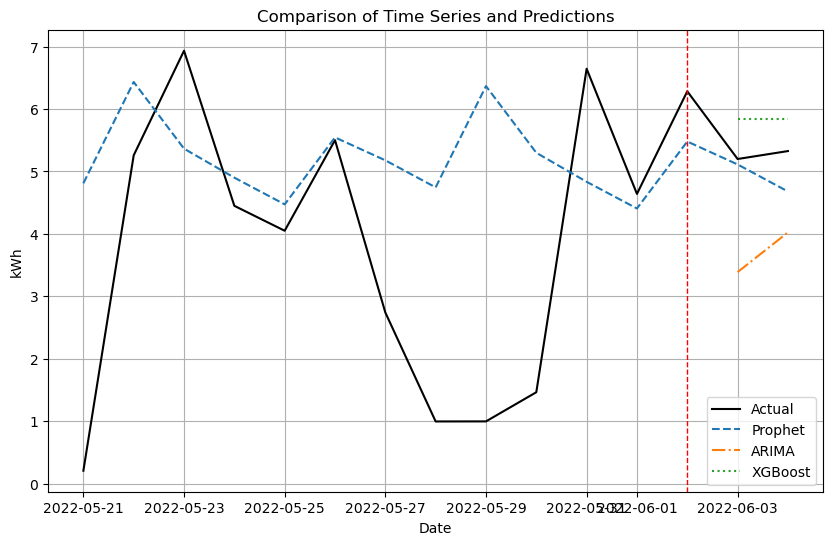

In [ ]:
plot_comparison_time_series(metadata, data_path, periods=2, displacement_periods=48, sample_rate='D')


In [ ]:
#plot_time_series_from_metadata(high_tariff_houses, data_path,'-' ,"high tariff houses",rolling=True)
#plot_time_series_from_metadata(low_tariff_samples, data_path, '-',"low tariff houses", rolling=True)
#plot_time_series_from_metadata(medical_stuff, data_path, '-',"medical instalations", rolling=True)
#plot_time_series_from_metadata(food_stuff, data_path, '-', "food factories", rolling=True)